In [40]:
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## to get the latex format
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Computer Modern",
    "font.size" : 25,
    "font.weight" :900,
    "legend.fontsize" : 25,
    "xtick.labelsize" : 20,
    "ytick.labelsize" : 20,
    # 'axes.labelcolor': 'black',
    'axes.labelsize': 20,
    'axes.labelweight': 900,
    # "figure.dpi":300,
    # 'legend.fontsize': 20.0,
    # 'legend.labelcolor': 'black',
    'text.latex.preamble' :r'''
    \boldmath
    \usepackage{amsmath}
    \renewcommand{\rmdefault}{cmr}  % Use Computer Modern Roman
    '''
})

In [ ]:
## path to the results from disease_metric_estimation results
curr_dir = os.getcwd()
gamma = 1 ## change it to recovery time (1/gamma) defined in the pipeline.sh
dup = 'True' ## variable to include or exclude duplicate sample points (put same as in pipeline.sh)

In [25]:
for folder_name in ['samples','sir','sir_feat']:
    # Directory path
    dir_path = f"{curr_dir}/{folder_name}"

    # Create directory if not exists
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Directory created: {dir_path}")
    else:
        print(f"Directory already exists: {dir_path}")


Directory already exists: /Users/c23093075/Downloads/Epidemics-on-Networks/samples
Directory already exists: /Users/c23093075/Downloads/Epidemics-on-Networks/sir
Directory already exists: /Users/c23093075/Downloads/Epidemics-on-Networks/sir_feat


In [32]:
network = "bcms_network"
start = 0
end = 2 ## same as max_nets in pipeline.sh
sample_size = 10
walks = 2
net_dir = "networks"
sample_dir = "samples"
sir_dir = 'sir'
agg_results='sir_feat'

In [38]:
# Define a function to run the commands
def run_command(script_name, *args):
    command = f"python3 {script_name} {' '.join(map(str, args))}"
    os.system(command)

# Step 1: Sample generation
run_command("sample_generation.py", network, start, end, sample_size, walks, net_dir, sample_dir)

# Step 2: SIR simulation
run_command("SIR_simulation.py", network, start, end, gamma, net_dir, sir_dir)

# Step 3: Disease metric estimation
run_command("disease_metric_estimation.py", network, start, end, gamma, dup, sir_dir, net_dir, sample_dir, agg_results)

# Step 4: Degree distribution
run_command("degree_distribution.py", network, start, end, net_dir, sample_dir, agg_results)


Reading network pickle...


100%|██████████| 1/1 [00:18<00:00, 18.98s/it]


bcms_network done!
Read network file!


100%|██████████| 2/2 [00:15<00:00,  7.54s/it]


Starting to write pickle file!
bcms_network done!
process starts!
RW starts
MHRW starts


100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


process starts!
process completed, writing it


## Plotting the disease metric comparison results

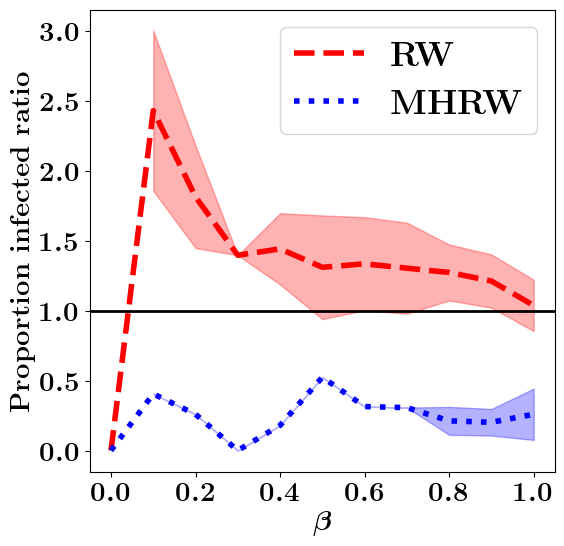

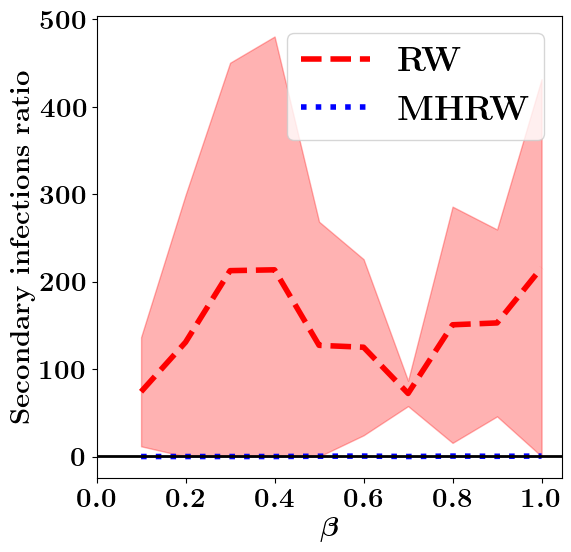

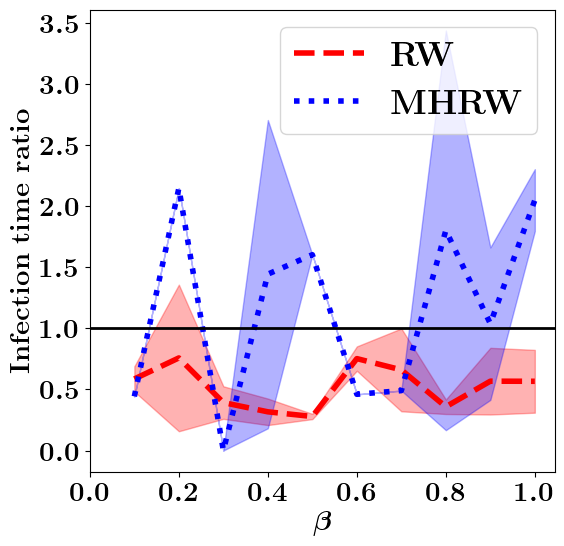

In [46]:
master_df = pd.DataFrame()
for algo in ['OG','RW','MHRW']:
    df = pickle.load(open(f"{curr_dir}/{agg_results}/{network}_{start}_{end}_{gamma}_{algo}.pkl","rb"))
    if dup != 'True': df['scaler'] = df['sample_size']
    else :
        if algo == 'OG' : df['scaler'] = 46512
        else : df['scaler'] = sample_size
    df['node_idx'] = df['node_idx']/df['scaler']
    master_df = pd.concat([master_df,df],axis=0)

plot_df = master_df.groupby(['beta','algo']).agg({'node_idx':['mean','std'],'second_inf':['mean','std'],'inf_time':['mean','std']}).reset_index()
plot_df.columns = ['_'.join(col).strip() for col in plot_df.columns.values]

custom_palette = {
    'OG': ['purple','o','-'], 
    'RW': ['red','v','--'], 
    'MHRW':['blue','s',':']
}
xlabeldict = {'node_idx': 'Proportion infected',
              'second_inf':'Secondary infections',
              'inf_time':'Infection time'}

for col in ['node_idx','second_inf','inf_time']:
  
    # Create a pivot table with aggregation
    pivot_df = pd.pivot_table(master_df, 
                            values=col, 
                            index='beta', 
                            columns='algo', 
                            aggfunc=['mean','std'],  # You can use 'mean', 'sum', 'max', etc.
                            fill_value=0)   # Fill missing values with 0

    pivot_df = pivot_df.reset_index()
    pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]

    pivot_df['std_OG'] = 0
    
    for algo in ['RW','MHRW']:
        pivot_df[f'{algo}_ratio'] = pivot_df[f'mean_{algo}']/ pivot_df['mean_OG']
        pivot_df[f'{algo}_ratio_max'] = (pivot_df[f'mean_{algo}']+pivot_df[f'std_{algo}'])/ (pivot_df['mean_OG']+pivot_df['std_OG'])
        pivot_df[f'{algo}_ratio_min'] = (pivot_df[f'mean_{algo}']-pivot_df[f'std_{algo}'])/ (pivot_df['mean_OG']-pivot_df['std_OG'])

        pivot_df[f'{algo}_ratio'] = pivot_df[f'{algo}_ratio'].apply(lambda x: 0 if x<0 else x)
        pivot_df[f'{algo}_ratio_max']  = pivot_df[f'{algo}_ratio_max'].apply(lambda x: 0 if x<0 else x)
        pivot_df[f'{algo}_ratio_min'] = pivot_df[f'{algo}_ratio_min'].apply(lambda x: 0 if x<0 else x)

    plt.figure(figsize=(6,6))
    for algo in ['RW','MHRW']:
        plt.plot(pivot_df['beta_'],pivot_df[f'{algo}_ratio'],label=r'\textbf{'+algo+'}',linewidth=4,linestyle=custom_palette[algo][2],color=custom_palette[algo][0])
        plt.fill_between(pivot_df['beta_'],
                        pivot_df[f'{algo}_ratio_min'],
                        pivot_df[f'{algo}_ratio_max'],
                        alpha=0.3,
                        color=custom_palette[algo][0]
                        )
        plt.xticks(np.arange(0,1.2,0.2))
    plt.axhline(y=1,color='black',linestyle='-',linewidth=2)
    plt.xlabel(r'\textbf{$\beta$}')
    plt.ylabel(r'\textbf{'+xlabeldict[col]+' ratio}')
    plt.legend()

